In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import plotly.express as px

df1 = pd.read_csv('data/23_merge_Data.csv').drop(['Unnamed: 0', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
print(df1.shape)
df1.head(2)

(100233, 29)


,고객ID,대출건수_1금융,대출건수_2금융,대출건수_3금융권,대출건수_기타,대출액_1금융,대출액_2금융,대출액_3금융,대출액_기타,유지기간_1금융,...,Cluster,Group,연령,성별,직업,추정소득,가구추정소득,가족원수,자녀평균연령,배우자직업
0,1,1,0,0,0,9001,9001,9001,0,1,...,0,A,50,1,공무원,5400,7700,4,24.0,주부
1,2,1,0,0,0,24001,0,24001,0,0,...,0,A,50,1,자영업,5500,8100,4,29.0,주부


In [66]:
import warnings

warnings.filterwarnings('ignore')

### 17-3. 차원 축소

- 알고리즘을 이용해 x 변수들의 수를 데이터 간 관계나 거리등을 이용하여 축소하는 기법
- 지도 학습에서 차원의 저주 문제가 발생하거나, 자원을 효과적으로 활용하며 학습을 수행해야 할 때
- 변수들의 특성을 분해하거나 축소하여 변수를 줄이는 기법(비지도학습, 특성공학)

### 특이값 분해(singular value decomposition, svd)

- 주어진 데이터를 행렬 곱으로 분해하여 축소하는 기법
- 주어딘 데이터를 행렬 A로 가정하여 분해
$$A = U \Sigma V^{\mathrm{T}}$$
- U: A의 왼쪽 특이 벡터로 구성된 직교 행렬
- sigma: A의 특징값을 대각선으로 가지는 대각행렬
- V: A의 오른쪽 특이 벡터로 구성된 직교 행렬

- SVD 알고리즘 특징:
  - 데이터의 분산이 큰 방향(중요한 정보가 많이 담긴 방향)으로 데이터를 축소
  - 데이터의 특정 특징을 유지하면서 더욱 작은 차원으로 축소
  - 데이터 상에 존재하는 특이값만 선택되므로, 모델링을 수행하는 등의 작업을 수행할 때, 각 모델의 성능 향상에 도움을 줌
- 대출 가능 금액을 예측하는 회귀모델을 구성

In [4]:
df1.columns

Index(['고객ID', '대출건수_1금융', '대출건수_2금융', '대출건수_3금융권', '대출건수_기타', '대출액_1금융',
       '대출액_2금융', '대출액_3금융', '대출액_기타', '유지기간_1금융', '유지기간_2금융', '신용카드발급수',
       '신용카드유지기간', '보증건수', '보증금액', '대출연체여부', '대출건수총합', '대출액총합', '유지기간평균',
       'Cluster', 'Group', '연령', '성별', '직업', '추정소득', '가구추정소득', '가족원수',
       '자녀평균연령', '배우자직업'],
      dtype='object')

In [5]:
x = df1[['신용카드발급수', '신용카드유지기간', '보증건수', '보증금액',  '추정소득', '가구추정소득', '가족원수', '자녀평균연령', '유지기간평균',]]
y = df1['대출액총합']

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, classification_report

from sklearn.compose import make_column_transformer


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1234)

**차원축소 기법이 없는 모델 구성**

In [8]:
pipe1 = make_pipeline(SimpleImputer(strategy='median'),
                     StandardScaler(), RandomForestRegressor())

In [10]:
hyper = {'randomforestregressor__max_depth': range(3, 10)}
grid_model1 = GridSearchCV(pipe1, param_grid=hyper, cv = 3, n_jobs=-1)
grid_model1.fit(x_train, y_train)
best_model1 = grid_model1.best_estimator_

In [11]:
def eval_regression(model):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    print('학습성능 R2', r2_score(y_train, y_train_pred))
    print('학습성능 mse', mean_squared_error(y_test, y_test_pred))
    print('일반화성능 R2', r2_score(y_train, y_train_pred))
    print('일반화성능 mse', mean_squared_error(y_test, y_test_pred))

eval_regression(best_model1)

학습성능 R2 0.11470091796882542
학습성능 mse 62827051473.87589
일반화성능 R2 0.11470091796882542
일반화성능 mse 62827051473.87589


**SVD 기법 적용 모델**

In [12]:
from sklearn.decomposition import TruncatedSVD

In [13]:
pipe2 = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(),
                     TruncatedSVD(n_components=4, random_state=1234),
                     RandomForestRegressor())
# 현재 9개의 변수로 학습되던 x를 4개의 column으로 차원을 축소하여 학습을 수행

In [15]:
grid_model2 = GridSearchCV(pipe2, param_grid=hyper, cv=3, n_jobs=-1)
grid_model2.fit(x_train, y_train)
best_model2 = grid_model2.best_estimator_

In [16]:
eval_regression(best_model2)

학습성능 R2 0.09024528065580562
학습성능 mse 63811322229.15774
일반화성능 R2 0.09024528065580562
일반화성능 mse 63811322229.15774


In [17]:
# 변수중요도를 통해 실제 학습된 변수의 특성 중요도 값을 비교
best_model1['randomforestregressor'].feature_importances_

array([0.23215103, 0.13609403, 0.03164234, 0.27971623, 0.04489252,
       0.05373915, 0.02183451, 0.02937307, 0.17055711])

In [18]:
best_model2['randomforestregressor'].feature_importances_
# 차원 축소를 수행하고, 지도학습 모형을 적용하면, 회귀계수나 변수중요도와 같은 인자들의 직관적 해석이 불가능

array([0.4815572 , 0.09508266, 0.32359546, 0.09976468])

### 주성분 분석(principal component analysis, pca)

- 특성 간의 상관관계를 기반으로 공분산을 활용해 정보 손시을 최소화 하면서 차원을 축소하는 기법
- 데이터를 축약하여 정보를 쉽게 표현하는 방법(고차원 특성-> 저차원 주성분)
- 데이터의 각 공분산 행렬에 대해 svd를 수행한 기법이 pca
- 분석 전 처리:
  - x 변수 간 특성의 단위(scale)이 유사, 사전에 표준화 작업을 필히 수행
  - 특성의 단위가 유사하면 공분산행렬을 이용해 계산
  - 특성의 단위가 차이가 발생하는 경우엔 상관계수를 행렬로 처리하여 계산
- 단계:
  1. 데이터 정규화
     - pca를 수행하기 전 데이터의 스케일링을 수행하여, 각 변수의 스케일을 동등하게 변환
     - 모든 데이터 값의 평균을 0으로 보정, 각 변수에서 평균값의 차이를 계산
  2. 공분산 행렬 계산
     - 데이터의 공분산 행격 계산
     - 이 행렬은 데이터 간의 상관관계를 나타내는 행렬, pca에서 주성분을 찾는데 사용
$$\mathbf{C} = \frac{1}{n-1} \mathbf{X}_{\text{centered}}^{T} \mathbf{X}_{\text{centered}}$$

3. 고유값 분해(eigenvalue decomposition)
   - 공분산 행렬(c)의 고유값과 고유 벡터를 계싼
   - 공분산 행렬을 고유값 분해하여, 주성분과 고유값을 계산
   - 고유벡터: 차원을 줄임에 있어 새로운 좌표계의 축
   - 교유값: 각 축(주성분)이 설명하는 분산의 크기
4. 주성분을 선택
   - 주어진 분산의 비율을 보존하면서 주성분을 선택
   - 보통 누적된 설명분산이 일정비율 이상(90%)되도록 축소
5. 데이터 변환
   - 선택된 주성분을 이용해 데이터를 새로운 축으로 변환

- 활용
  - 변수가 많을 때, 주요 특성을 나타내는 성분 추출을 통한 변수 축소
  - pca는 주성분이라고 불리는 새로운 변수들이 생성되고, 주성분은 데이터의 분산을 최대화 하는 방향으로 정의됨(이는 데이터의 주요한 패턴을 찾는데 사용) -> 주요 지표들 이용해 이상발생 모니터링

In [19]:
from sklearn.decomposition import PCA

In [20]:
pipe3 = make_pipeline(SimpleImputer(strategy='median'),
                     StandardScaler(), PCA(n_components=4, random_state=1234),
                     RandomForestRegressor())

In [21]:
grid_model3 = GridSearchCV(pipe3, param_grid=hyper, cv=3, n_jobs=-1)
grid_model3.fit(x_train, y_train)
best_model3 = grid_model3.best_estimator_

In [22]:
eval_regression(best_model3)

학습성능 R2 0.08985470382011307
학습성능 mse 63805520681.36373
일반화성능 R2 0.08985470382011307
일반화성능 mse 63805520681.36373


### 션형 판별 분석(linear discriminant analysis, LDA)

- LDA기법은 분류에 있어, 클래스 간 분리를 최대화하는 바향으로 데이터를 저차원공간으로 변환
- Y값에 대한 개입(Y의 각 클래스의 분리가 최대가 되도록 차원을 축소)
- 분류 문제에서 결정 경계를 더욱 명확히 하며, 차원을 축소시키는 기법
- pca와 달리 y를 사용하여 두 클래스 또는 여러 클래스를 구분하는 경계를 찾는것이 특징
- 클래스 분류 항목에 맞게 x를 축소하여 사용하는 형태로 알고리즘이 작동(다중분류)
  - LDA 차원수 = 클래스 항목수 - 1
  - 이진분류에서는 데이터가 최대 하나의 축으로 차원이 축소되어 성능이 되려 저하될 가능성이 높음
- LDA 원리: 클래스 간 분산(또는 평균거리)를 최대화 하고, 클래스 내의 분산을 최소화하는 투영(분류선)을 찾는 것

- 특징:
  - PCA는 분산을 최대화 하는 방향으로 축을 찾음(분산을 최대로 넓혀야, x변수들의 특성을 반영)
  - lda는 클래스간의 분리를 최대화 하는 방향으로 축을 찾음

In [24]:
# 고객의 정보를 입력했을 때, 해당 곡객이 어떤 군집으로 분류될지 결정하는 모델을 구성
df1['Group'].value_counts()

Group
A    70846
D    22545
B     5801
C     1041
Name: count, dtype: int64

In [25]:
df1['age'] = df1['연령'].replace({'*':np.nan}).astype(float)

In [45]:
x = df1[['age', '성별', '직업', '추정소득', '가구추정소득', '가족원수', '자녀평균연령', '배우자직업']]
y = df1['Group']


In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1234)

In [47]:
pipe4 = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
pipe5 = make_pipeline(SimpleImputer(strategy='most_frequent'),
                      OneHotEncoder(handle_unknown='ignore',sparse_output=False ))
pipe6 = make_column_transformer( (pipe4, x.describe().columns),
                                 (pipe5, x.describe(include='object').columns))

In [48]:
# LDA 없는 모형
pipe7 = make_pipeline(pipe6, RandomForestClassifier())


In [49]:
# LDA 있는 모형
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipe8 = make_pipeline(pipe6, LinearDiscriminantAnalysis(n_components=3), RandomForestClassifier())

In [62]:
hyper = {'randomforestclassifier__max_depth':[3, 4, 5], 'randomforestclassifier__class_weight':['balanced']}
grid_model4 = GridSearchCV(pipe7, param_grid=hyper, cv=3, n_jobs=-1)
grid_model4.fit(x_train, y_train)
best_model4 = grid_model4.best_estimator_

In [63]:
grid_model5 = GridSearchCV(pipe8, param_grid=hyper, cv=3, n_jobs=-1)
grid_model5.fit(x_train, y_train)
best_model5 = grid_model5.best_estimator_

In [64]:
y_train_pred = best_model4.predict(x_train)
y_test_pred = best_model4.predict(x_test)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           A       0.76      0.56      0.65     53204
           B       0.09      0.19      0.12      4309
           C       0.02      0.52      0.05       786
           D       0.27      0.16      0.20     16875

    accuracy                           0.45     75174
   macro avg       0.29      0.36      0.25     75174
weighted avg       0.61      0.45      0.51     75174

              precision    recall  f1-score   support

           A       0.76      0.55      0.64     17642
           B       0.09      0.18      0.12      1492
           C       0.02      0.40      0.03       255
           D       0.27      0.17      0.21      5670

    accuracy                           0.44     25059
   macro avg       0.28      0.32      0.25     25059
weighted avg       0.60      0.44      0.50     25059



In [65]:
y_train_pred = best_model5.predict(x_train)
y_test_pred = best_model5.predict(x_test)
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           A       0.76      0.52      0.62     53204
           B       0.09      0.20      0.12      4309
           C       0.02      0.55      0.04       786
           D       0.29      0.13      0.18     16875

    accuracy                           0.42     75174
   macro avg       0.29      0.35      0.24     75174
weighted avg       0.61      0.42      0.49     75174

              precision    recall  f1-score   support

           A       0.75      0.52      0.61     17642
           B       0.09      0.19      0.12      1492
           C       0.01      0.42      0.03       255
           D       0.29      0.13      0.18      5670

    accuracy                           0.41     25059
   macro avg       0.29      0.31      0.23     25059
weighted avg       0.60      0.41      0.48     25059



- x 데이터가 적은 경우엔 차원 축소기법을 적용했을 때, 성능이 되려 낮아질 수 있음
- 반영해야하는 데이터의 특성이나 요소들이 차원축소를 통해 제외되기 때문
- x데이터가 많으면, 차원의 저주 문제가 해결되며 일반화 성능이 올라갈 수 있음

# 18. 딥 러닝(deep learning)

- 딥러닝은 신경망 모델(artificial neural network, ann)을 활용해 표현층(layer)을 학습
- 신경망 모델:
  - 데이터가 여러 필터(층, layer, filter)를 거쳐가며, 의미있는 정보를 추출하는 형태 알고리즘
  - 여러 층을 거쳐가며 데이터가 처리되므로, 이를 deep learning이라고 부름
  - 사람의 신경세포를 본따 초기 신경망 알고리즘인 퍼셉트론이라고 부르는 모형을 발전시킴
- 신경망 알고리즘 장점
  1. 신경망 알고리즘은 거의 모든 함수를 추정할 수 있음(보편근사의 정리)
  2. 높은 성능과 확장성을 제공, 어떤 유형의 데이터든 잘 작동이 됨
  3. 확장성: 알고리즘들이 서로 다른 분야에 대한 확장이 가능
  4. 비정형 데이터에 대한 처리가 일어남

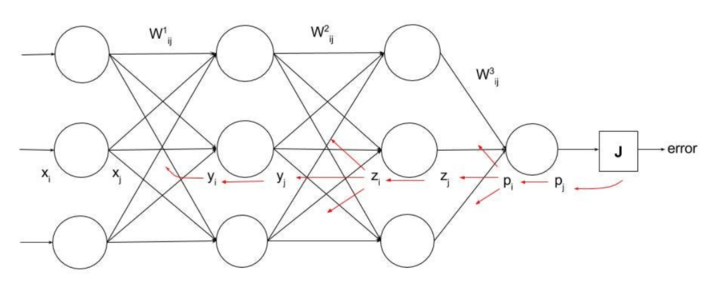

- 층(layer)
  - 각 데이터가 처리되는 함수들이 존재하는 층
  - 이 층이 하나만 있는 경우: 단층 신경망 알고리즘
  - 층이 여러겹 쌓여 있는 경우: 다층 신경망 알고리즘
- 노드(Node)
  - 각 층에 존재하는 데이터 처리 함수
  - 하나의 층(layer)안에 여러개의 node가 존재
  - 앞 layer에 날아온 정보를 node가 받아 계산하여 처리
  - 이 node내 함수가 어떤 식으로 구성되어있는지에 따라 성능이 달라짐
- 가중치(weight)
  - node내 존재하는 데이터처리에 대한 파라미터로 학습이 수행되며 지속적으로 update되는 값
  - deep learning은 각 layer 내 존재하는 node속 weight를 어떻게 잘 update하느냐의 문제
- 활성화 함수(activation function)
  - 각 node에서 계산된 결과를 반환하는 함수식
  - 활성함수는 간단한 선형회귀 함수부터, 삼각함수, 시그모이드함수 등 다양한 함수들이 존재
  - 각 활성함수에 의해 계산된 값들이 여러 later를 통과
- 손실함수(cost function & loss function)
  - 예측값과 실제값의 차이를 계싼하는 함수
  - 신경망 출력 값의 제어 지표가 되며, 해당 함수를 통해 각 node에 있는 weight값이 update

- **신경망 알고리즘 작동 원리**
- Feedforward(순전파)
  - x 값이 신경망 알고리즘을 타고가며 예측값을 계산
  - 초기엔 임의로 세팅된 node내 weight에 의해 계산이 수행되어 결과 y값 도출
  - 각 layer를 통과해 나가며, 더 복잡한 특성을 표현 및 예측
- backpropagation(역전파)
  - 순전파를 타고와 계산된 예측값과 실제값을 비교한 뒤, 손실함수에 의해 출력 단에서 가장 가까운 weight가 순차적으로 update
  - 두 값의 차이(실제값과 예측값의 차이)가 낮아질 수 있는 방향으로 손실함수에 의해 최적화, 최적화를 수행하며, 앞쪽 node의 weight update
- training loop를 통해, 최초로 부여받은 random weight값을 cost function이 가장 낮아지는 방향으로 순전파오 ㅏ역전파가 반복되며 수행
  1. 초기화 실시: 각 layer 내 node 존재하는 weight를 임의의 값으로 설정
  2. 순전파 수행: 입력값이 layer를 통과하며 예측값을 생성
  3. 손실 계산: 실제값과 예측값을 비교
  4. 역전파 수행: 손실함수에서 발생된 오차를 줄이기 위해, 초기값으로 세팅된 weight를 변경
  5. 다시 순전파부터 반복

In [68]:
from keras import models
from keras.layers import Dense
from keras.models import Sequential

In [69]:
df1.columns

Index(['고객ID', '대출건수_1금융', '대출건수_2금융', '대출건수_3금융권', '대출건수_기타', '대출액_1금융',
       '대출액_2금융', '대출액_3금융', '대출액_기타', '유지기간_1금융', '유지기간_2금융', '신용카드발급수',
       '신용카드유지기간', '보증건수', '보증금액', '대출연체여부', '대출건수총합', '대출액총합', '유지기간평균',
       'Cluster', 'Group', '연령', '성별', '직업', '추정소득', '가구추정소득', '가족원수',
       '자녀평균연령', '배우자직업', 'age'],
      dtype='object')

In [72]:
x = df1[['추정소득', '가구추정소득', '가족원수',  '신용카드유지기간', '보증건수', '보증금액', '대출건수총합', '대출액총합', '유지기간평균','신용카드발급수']]
y = df1['대출연체여부']

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1234)

In [75]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics=['recall'])
result = model.fit(x_train, y_train, epochs=20, validation_split=0.4)

Epoch 1/20
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 155.8961 - recall: 0.0512 - val_loss: 650.6191 - val_recall: 0.6641
Epoch 2/20
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 71.4493 - recall: 0.0671 - val_loss: 26.7089 - val_recall: 0.0791
Epoch 3/20
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 57.4081 - recall: 0.0750 - val_loss: 34.3447 - val_recall: 0.5733
Epoch 4/20
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 49.3403 - recall: 0.0860 - val_loss: 56.2753 - val_recall: 0.0039
Epoch 5/20
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 47.2265 - recall: 0.0674 - val_loss: 24.1887 - val_recall: 0.0178
Epoch 6/20
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 42.6531 - recall: 0.0781 - val_loss: 33.4686 - val_recall: 0.0109
Epoch 7/20
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 30.5673 - recall: 0.0702 - val_loss: 28.4606 - val_recall: 0.0054
Epoch 8/20
1410/1410 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 26.4029 - recall: 0.0818 - val_loss: 7.8

- model = Sequential()
  - 이 코드는 sequential모델을 생성
  - sequential모델은 keras 라이브러리에서 간단한 신경망을 구성하는데 사용하는 가장 기본적인 모델
  - sequential모델: 순차적으로 layer를 쌓아 모델을 구성
  - 순차적으로 순전파와 역전파의 반복을 통해 학습이 수행
- model.add()
  - 순차적으로 layer를 쌓을 수 있는 층에 하나의 layer를 추가
 
- Dense(16, activation='relu', input_shape=(10,))
  - 첫 번째 layer로 16개의 node를 가지는 dense(전결합) layer를 추가
  - activation='relu': 활성화 함수의 종류를 작성, relu이름의 활성함수를 이용하여 출력값을 계산
  - input_shape = (10,): 10개 column으로 구성된 데이터를 입력 받음
- model.add(Dense(16, activation='relu'))
  - 두번째 layer(hidden layer, 은닉층)를 16개의 node가 있고, 활성함수가 relu함수로 구정쇤 층을 추가
 
- model.add(Dense(1, activation='sigmoid'))
  - 마지막 layer엔 node가 1개짜리인 필터, 활성함수는 sigmoid
  - 출력층 1개의 노드로 하나의 출력이 나오게끔 설정(예측하려는 결과, Y값이 하나의 값으로 도출)
  - 활성함수가 sigmoid형태기 때문에 출력 결과는 0~1 사이의 값이 1개가 출력
- model.compile(optimizer = 'rmsprop', loss='binary_crossentropy', metrics=['recall'])
  - optimizer= : 어떤 최적화 알고리즘을 이용해 weight를 update할 것인지 결정
  - loss=: 순전파에 의해 계산된 실제값과 예측값의 차이를 계산하는 손실함수
  - metrics=: 최적화 알고리즘이 어떤 지표를 이용해 weight update할지 결정
- result = model.fit(x_train, y_train, epochs=20, validation_split=0.4)
  - epochs= : 데이터 셋을 20번 반복하여 학습
  - validation_split: 교차검증을 위한 validation set의 비율 40%

In [78]:
# trainging loop evaluation(각 반복 회차별 평가 지표)
pd.DataFrame(result.history).reset_index()
# index가 의미하는 바는 각 training loop 회차

,index,loss,recall,val_loss,val_recall
0,0,98.619888,0.053534,650.619141,0.664081
1,1,67.243462,0.076923,26.708944,0.079131
2,2,59.851482,0.074324,34.344666,0.573313
3,3,48.907265,0.076403,56.275276,0.003879
4,4,44.542736,0.076923,24.188747,0.017843
5,5,37.816105,0.080042,33.468594,0.010861
6,6,29.104113,0.079002,28.460632,0.005431
7,7,22.779615,0.089397,7.884146,0.009310
8,8,13.276723,0.082121,5.641328,0.038014
9,9,10.032545,0.076923,2.170113,0.108611
